In [82]:
class Defaults:
    RANDOM_SEED: int = 42
    DATASET_PATH: str = "../../data/DVM"
    BOUNDARY_OF_REPRESENTATIVENESS: float = 0.01
    TRAIN_SHARE: float = 0.7
    VAL_SHARE: float = 0.15
    TEST_SHARE: float = 0.15
    BATCH_SIZE: int = 64

In [83]:
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

from collections import Counter
from datetime import datetime
from PIL import Image
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from typing import Set, List
from colorama import Fore

In [84]:
%%capture
torch.manual_seed(Defaults.RANDOM_SEED)
random.seed(Defaults.RANDOM_SEED)

In [85]:
class DVM(Dataset):
    def __init__(self, root_dir: str, transform=None, shuffle=True):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for brand in os.listdir(root_dir):
            brand_path = os.path.join(root_dir, brand)
            if not os.path.isdir(brand_path):
                continue
            for year in os.listdir(brand_path):
                year_path = os.path.join(brand_path, year)
                if not os.path.isdir(year_path):
                    continue
                for image_file in os.listdir(year_path):
                    if image_file.endswith(".jpg"):
                        image_path = os.path.join(year_path, image_file)
                        self.image_paths.append(image_path)

                        label = DVM._extract_color_from_filename(image_file)
                        self.labels.append(label)

        if shuffle:
            combined = list(zip(self.image_paths, self.labels))
            random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)

        self._update_statistics()

    def remove_labels(self, labels: Set[str]):
        combined = list(zip(self.image_paths, self.labels))
        self.image_paths, self.labels = zip(
            *[entry for entry in combined if entry[1] not in labels]
        )
        self._update_statistics()

    def _update_statistics(self):
        self.labels_set = set(self.labels)
        self.label_indexes = {color: i for i, color in enumerate(self.labels_set)}
        self.classes_count = len(self.labels_set)

    @staticmethod
    def _extract_color_from_filename(filename: str) -> str:
        """
        Example:
            >>> DVM._extract_color_from_filename("Abarth$$595$$2013$$Black$$2_4$$100$$image_1.jpg")
            "Black"
        """
        parts = filename.split("$$")
        color = parts[3]
        return color

    def size(self) -> int:
        return len(self.image_paths)

    def get_labels_set(self) -> Set[str]:
        return set(self.labels_set)

    def get_classes_count(self) -> int:
        return self.classes_count

    def __len__(self) -> int:
        return self.size()

    def __getitem__(self, idx: int) -> torch.FloatTensor:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self._one_hot_encode(self.labels[idx])
        return image, label

    def _one_hot_encode(self, label: str) -> torch.FloatTensor:
        result = torch.zeros(self.classes_count)
        result[self.label_indexes[label]] = 1
        return result

Загрузка набора данных:

In [86]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dvm = DVM(root_dir=Defaults.DATASET_PATH, transform=transform)

Пример изображения из DVM:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


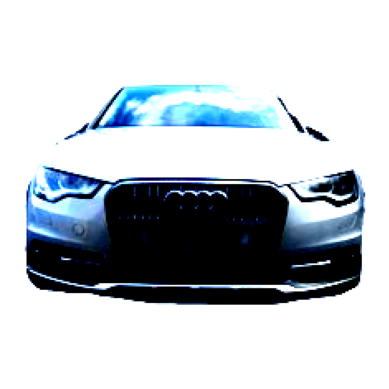

In [87]:
image, label = dvm[0]

plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

Размер набора данных:

In [88]:
n = dvm.size()
n

61827

Число классов:

In [89]:
dvm.get_classes_count()

23

In [90]:
label_counter = Counter(dvm.labels)
label_counter

Counter({'Black': 14317,
         'Grey': 9474,
         'White': 9395,
         'Blue': 8483,
         'Silver': 7770,
         'Red': 6095,
         'Unlisted': 1516,
         'Brown': 911,
         'Green': 777,
         'Yellow': 667,
         'Beige': 600,
         'Orange': 559,
         'Purple': 362,
         'Bronze': 329,
         'Gold': 217,
         'Multicolour': 196,
         'Pink': 87,
         'Turquoise': 26,
         'Maroon': 26,
         'Burgundy': 9,
         'Magenta': 9,
         'Indigo': 1,
         'Navy': 1})

In [91]:
m = Defaults.BOUNDARY_OF_REPRESENTATIVENESS * n
non_represented_labels = [
    label for label, count in label_counter.items() if count < m
] + ["Unlisted"]
non_represented_labels

['Gold',
 'Bronze',
 'Beige',
 'Multicolour',
 'Pink',
 'Purple',
 'Orange',
 'Turquoise',
 'Maroon',
 'Burgundy',
 'Magenta',
 'Indigo',
 'Navy',
 'Unlisted']

In [92]:
dvm.remove_labels(non_represented_labels)

In [93]:
n = dvm.size()
n

57889

In [94]:
dvm.get_classes_count()

9

Разделение набора данных на тренировочную, валидационную и тестовую выборки:

In [95]:
train_size = int(Defaults.TRAIN_SHARE * n)
val_size = int(Defaults.VAL_SHARE * n)
test_size = n - train_size - val_size

train, val, test = random_split(dvm, [train_size, val_size, test_size])

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 40522
Validation size: 8683
Test size: 8684


In [96]:
train_loader = DataLoader(train, batch_size=Defaults.BATCH_SIZE)
val_loader = DataLoader(val, batch_size=Defaults.BATCH_SIZE)
test_loader = DataLoader(test, batch_size=Defaults.BATCH_SIZE)

Для классификации была выбрана архитектура [MobileNetV2](https://arxiv.org/pdf/1801.04381).

In [97]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                channels,
                channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                groups=channels,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [98]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor):
        super(Bottleneck, self).__init__()

        layers: List[nn.Module] = []

        hidden_channels = in_channels * expansion_factor
        if expansion_factor != 1:
            layers.extend(
                [
                    nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(hidden_channels),
                    nn.ReLU6(inplace=True),
                ]
            )

        layers.extend(
            [
                DepthwiseSeparableConv(hidden_channels, stride=stride),
                nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            ]
        )

        self.block = nn.Sequential(*layers)
        self.use_residual_connection = stride == 1 and in_channels == out_channels

    def forward(self, x):
        if self.use_residual_connection:
            return x + self.block(x)
        return self.block(x)

In [99]:
class MobileNetV2(nn.Module):
    def __init__(self, classes_count: int, dropout_probability: float = 0.2):
        super(MobileNetV2, self).__init__()

        in_channels = 32
        feature_extraction: List[nn.Module] = [
            nn.Conv2d(
                in_channels=3,
                out_channels=in_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
        ]

        table = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for expansion_factor, out_channels, count, initial_stride in table:
            for i in range(count):
                stride = initial_stride if i == 0 else 1
                feature_extraction.append(
                    Bottleneck(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=stride,
                        expansion_factor=expansion_factor,
                    )
                )
                in_channels = out_channels

        features_count = 1280
        feature_extraction.extend(
            [
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=features_count,
                    kernel_size=1,
                    bias=False,
                ),
                nn.BatchNorm2d(features_count),
                nn.ReLU6(inplace=True),
            ]
        )

        self.feature_extraction = nn.Sequential(*feature_extraction)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_probability),
            nn.Linear(in_features=features_count, out_features=classes_count),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He initialization
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.feature_extraction(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1)
        y = self.classifier(features)
        return y

In [100]:
def get_parameters_count(model):
    result = 0
    for parameter in list(model.parameters()):
        n = 1
        for dimention in list(parameter.size()):
            n *= dimention
        result += n
    return result

In [101]:
model = MobileNetV2(classes_count=dvm.get_classes_count())
get_parameters_count(model)

2235401

Таким образом, модель имеет примерно 2,25 М параметров.

In [102]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [ ]:
def calculate_f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")


def get_labels(one_hot_encoded):
    return torch.argmax(one_hot_encoded, dim=1).cpu().numpy()


def log_message(msg: str, color=None):
    msg = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {msg}"
    if color is not None:
        msg = color + msg + Fore.RESET
    print(msg)


def run(
    model: nn.Module,
    data_loader: DataLoader,
    train: bool = False,
    criterion: nn.Module = None,
    optimizer: optim.Optimizer = None,
):
    model.to(device)

    if train:
        model.train()
        assert criterion is not None and optimizer is not None
    else:
        model.eval()

    ys = []
    ps = []

    context = torch.enable_grad() if train else torch.inference_mode()

    with context:
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            if train:
                optimizer.zero_grad()
            p = model(x)
            if train:
                loss = criterion(p, y)
                loss.backward()
                optimizer.step()

            ys.extend(get_labels(y))
            ps.extend(get_labels(p))

    return calculate_f1_macro(ys, ps)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    filename: str,
    num_epochs: int,
):
    log_message("Start training")
    best_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()

        train_f1_macro = run(
            model, train_loader, train=True, criterion=criterion, optimizer=optimizer
        )
        log_message(f"Epoch {epoch+1}/{num_epochs}, F1_macro: {train_f1_macro:.4f}")

        val_f1_macro = run(model, val_loader)
        is_best = val_f1_macro > best_f1

        log_message(
            f"Validation F1_macro: {val_f1_macro:.4f}",
            color=Fore.GREEN if is_best else Fore.YELLOW,
        )

        if is_best:
            best_f1 = val_f1_macro
            torch.save(model.state_dict(), filename)
            log_message(f"Model saved to {filename}")

    log_message(f"Best validation F1_macro: {best_f1:.4f}")


def test_model(model, test_loader):
    log_message("Start testing")
    log_message(f"Test F1_macro: {run(model, test_loader):.4f}")

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
my_mobilenet_v2_pth = "my_mobilenet_v2.pth"

train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    filename=my_mobilenet_v2_pth,
    num_epochs=10,
)

2024-11-11 09:11:32 - Start training
2024-11-11 09:17:01 - Epoch 1/10, F1_macro: 0.5444
2024-11-11 09:17:29 - Validation F1_macro: 0.6028
2024-11-11 09:17:29 - Model saved to my_mobilenet_v2.pth
2024-11-11 09:22:50 - Epoch 2/10, F1_macro: 0.6755
2024-11-11 09:23:21 - Validation F1_macro: 0.6748
2024-11-11 09:23:21 - Model saved to my_mobilenet_v2.pth
2024-11-11 09:28:46 - Epoch 3/10, F1_macro: 0.7287
2024-11-11 09:29:13 - Validation F1_macro: 0.6987
2024-11-11 09:29:13 - Model saved to my_mobilenet_v2.pth
2024-11-11 09:35:10 - Epoch 4/10, F1_macro: 0.7695
2024-11-11 09:35:44 - Validation F1_macro: 0.7339
2024-11-11 09:35:44 - Model saved to my_mobilenet_v2.pth
2024-11-11 09:44:09 - Epoch 5/10, F1_macro: 0.8044
2024-11-11 09:44:34 - Validation F1_macro: 0.7480
2024-11-11 09:44:34 - Model saved to my_mobilenet_v2.pth
2024-11-11 09:49:49 - Epoch 6/10, F1_macro: 0.8251
2024-11-11 09:50:14 - Validation F1_macro: 0.7423
2024-11-11 09:55:25 - Epoch 7/10, F1_macro: 0.8493
2024-11-11 09:55:49 -

In [111]:
train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    filename=my_mobilenet_v2_pth,
    num_epochs=5,
)

2024-11-11 10:51:58 - Start training
2024-11-11 11:00:57 - Epoch 1/5, F1_macro: 0.8904
2024-11-11 11:01:58 - Validation F1_macro: 0.7924
2024-11-11 11:01:58 - Model saved to my_mobilenet_v2.pth
2024-11-11 11:08:25 - Epoch 2/5, F1_macro: 0.8910
2024-11-11 11:08:49 - Validation F1_macro: 0.7924
2024-11-11 11:15:55 - Epoch 3/5, F1_macro: 0.8916
2024-11-11 11:16:20 - Validation F1_macro: 0.7924
2024-11-11 11:31:16 - Epoch 4/5, F1_macro: 0.8907
2024-11-11 11:31:45 - Validation F1_macro: 0.7924
2024-11-11 11:40:48 - Epoch 5/5, F1_macro: 0.8889
2024-11-11 11:41:12 - Validation F1_macro: 0.7924
2024-11-11 11:41:12 - Best validation F1_macro: 0.7924


In [112]:
model.load_state_dict(torch.load(my_mobilenet_v2_pth, weights_only=True))
test_model(model, test_loader)

2024-11-11 11:42:25 - Start testing
2024-11-11 11:42:51 - Test F1_macro: 0.8061


Загрузка предобученной на ImageNet модели.

In [106]:
pretrained_model = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "mobilenet_v2",
    weights=models.MobileNet_V2_Weights.DEFAULT,
).to(device)

Using cache found in /Users/igor/.cache/torch/hub/pytorch_vision_v0.10.0


Замена головы.

In [107]:
for parameter in pretrained_model.features.parameters():
    parameter.requires_grad = False

pretrained_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features=1280, out_features=dvm.get_classes_count()),
)

for module in pretrained_model.classifier.modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0, 0.01)
        nn.init.zeros_(module.bias)

In [108]:
pretrained_mobilenet_v2_pth = "pretrained_mobilenet_v2.pth"

In [109]:
optimizer = optim.Adam(pretrained_model.classifier.parameters(), lr=5e-4)

train_model(
    pretrained_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    filename=pretrained_mobilenet_v2_pth,
    num_epochs=10,
)

2024-11-11 10:13:17 - Start training
2024-11-11 10:15:23 - Epoch 1/10, F1_macro: 0.4963
2024-11-11 10:15:46 - Validation F1_macro: 0.6045
2024-11-11 10:15:46 - Model saved to pretrained_mobilenet_v2.pth
2024-11-11 10:17:53 - Epoch 2/10, F1_macro: 0.6341
2024-11-11 10:18:16 - Validation F1_macro: 0.6587
2024-11-11 10:18:16 - Model saved to pretrained_mobilenet_v2.pth
2024-11-11 10:20:22 - Epoch 3/10, F1_macro: 0.6668
2024-11-11 10:20:46 - Validation F1_macro: 0.6751
2024-11-11 10:20:46 - Model saved to pretrained_mobilenet_v2.pth
2024-11-11 10:22:56 - Epoch 4/10, F1_macro: 0.6831
2024-11-11 10:23:22 - Validation F1_macro: 0.6857
2024-11-11 10:23:22 - Model saved to pretrained_mobilenet_v2.pth
2024-11-11 10:25:39 - Epoch 5/10, F1_macro: 0.6901
2024-11-11 10:26:04 - Validation F1_macro: 0.6899
2024-11-11 10:26:04 - Model saved to pretrained_mobilenet_v2.pth
2024-11-11 10:32:48 - Epoch 6/10, F1_macro: 0.6991
2024-11-11 10:33:58 - Validation F1_macro: 0.6920
2024-11-11 10:33:58 - Model save

In [110]:
pretrained_model.load_state_dict(
    torch.load(pretrained_mobilenet_v2_pth, weights_only=True)
)
test_model(pretrained_model, test_loader)

2024-11-11 10:47:55 - Start testing
2024-11-11 10:48:21 - Test F1_macro: 0.7142


# Выводы

- Дообучение модели явно оказывается более быстрым вариантом благодаря меньшему числу параметров;
- Обучение модели с нуля позволяет достигнуть более высоких результатов, благодаря тому, что лучше происходит feature extraction (ближе к задаче);
- Для улучшения дообучения, возможно, стоило разморозить несколько последних сверточных слоев.